**Курсовая работа по курсу "Системы обработки аналитической информации"**

*Арешин Станислав Олегович*

**Хакатон от компании Меркатор**

# Задание 

* Построить прогноз расхода в разрезе номенклатур на декабрь 

* Целевая переменная Expense

* Метрики бейслайна: 

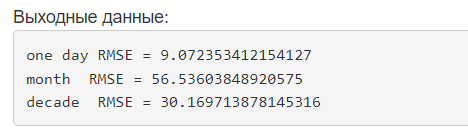

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

from lightgbm import LGBMRegressor

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

%matplotlib inline

# Загрузка и предобработка данных

В признаках Expense, Coming, InitialBalance есть проблемы в записях:

* Встречается \xa0 - это код пробела

* Дробная часть отделена ",", необходимо поменять на "."

* Также уберем лишние пробелы

Признаки id_Characteristic и id_Storage можно удалить, полезной информации в них, кажется, нет.

Необходимо сджоинить номенклатуры с аналогами.

In [2]:
df = pd.read_json('data_2021.json')
df.head()

,Date,id_Nomenclature,id_Characteristic,id_Storage,InitialBalance,Coming,Expense
0,2021-01-01,459cde5b-8207-11e9-80b7-f8bc12420fd1,00000000-0000-0000-0000-000000000000,6369adb0-fc99-11e7-80dc-bc305bede813,3,0,0
1,2021-01-01,29b507a2-820c-11e9-80b7-f8bc12420fd1,00000000-0000-0000-0000-000000000000,e609aa2d-d8fb-11e7-80da-bc305bede813,1,0,0
2,2021-01-01,dc95e633-8210-11e9-80b7-f8bc12420fd1,00000000-0000-0000-0000-000000000000,98ffa067-eba5-11e7-80dc-bc305bede813,1,0,0
3,2021-01-01,6ad3f78e-82bb-11e9-80b8-f8bc12420fd1,00000000-0000-0000-0000-000000000000,98ffa067-eba5-11e7-80dc-bc305bede813,20,0,0
4,2021-01-01,d18ddbe5-82ca-11e9-80b8-f8bc12420fd1,00000000-0000-0000-0000-000000000000,98ffa067-eba5-11e7-80dc-bc305bede813,1,0,0


In [3]:
df['Expense'].unique()

array(['0', '1', '3', '2', '300', '12', '4', '11,5', '1,55', '8,6', '5',
       '11', '2,5', '15', '7', '100', '60', '40', '6', '8', '10', '20',
       '180', '0,5', '7,5', '18', '6,5', '50', '8,5', '29', '14', '16',
       '65', '12,1', '22', '2,3', '160', '30', '200', '5,94', '210',
       '350', '260', '1\xa0800', '500', '2,07', '120', '9', '21', '54',
       '9,25', '5,5', '3\xa0000', '67', '150', '390', '58', '28', '0,3',
       '90', '15,5', '48', '27', '24', '17', '208', '1,5', '33', '4,5',
       '560', '17,5', '36', '10,5', '240', '25', '440', '197', '78', '68',
       '4\xa0000', '126', '4,4', '19', '1\xa0600', '12,4', '1\xa0000',
       '1\xa0250', '2\xa0100', '55', '5\xa0000', '205', '23', '3,5', '80',
       '13', '1,8', '2,4', '168', '121', '156', '70', '2,2', '16,5', '45',
       '31', '95', '84', '1\xa0500', '250', '740', '129', '171',
       '1\xa0200', '800', '400', '38', '3,6', '47', '7,1', '0,063',
       '0,07', '700', '35', '39', '140', '46', '66', '138', '42', '2

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y %H:%M:%S')

df['Expense'] = df['Expense'].astype(str)
df['Expense'] = df['Expense'].str.replace(',','.')
df['Expense'] = df['Expense'].str.replace(' ','')
df['Expense'] = df['Expense'].str.replace('\xa0','')
df['Expense'] = pd.to_numeric(df['Expense'])

df['InitialBalance'] = df['InitialBalance'].astype(str)
df['InitialBalance'] = df['InitialBalance'].str.replace(',','.')
df['InitialBalance'] = df['InitialBalance'].str.replace(' ','')
df['InitialBalance'] = df['InitialBalance'].str.replace("\xa0",'')
df['InitialBalance'] = pd.to_numeric(df['InitialBalance'])

df['Coming'] = df['Coming'].astype(str)
df['Coming'] = df['Coming'].str.replace(',','.')
df['Coming'] = df['Coming'].str.replace(' ','')
df['Coming'] = df['Coming'].str.replace("\xa0",'')
df['Coming'] = pd.to_numeric(df['Coming'])


df.head()

,Date,id_Nomenclature,id_Characteristic,id_Storage,InitialBalance,Coming,Expense
0,2021-01-01,459cde5b-8207-11e9-80b7-f8bc12420fd1,00000000-0000-0000-0000-000000000000,6369adb0-fc99-11e7-80dc-bc305bede813,3.0,0.0,0.0
1,2021-01-01,29b507a2-820c-11e9-80b7-f8bc12420fd1,00000000-0000-0000-0000-000000000000,e609aa2d-d8fb-11e7-80da-bc305bede813,1.0,0.0,0.0
2,2021-01-01,dc95e633-8210-11e9-80b7-f8bc12420fd1,00000000-0000-0000-0000-000000000000,98ffa067-eba5-11e7-80dc-bc305bede813,1.0,0.0,0.0
3,2021-01-01,6ad3f78e-82bb-11e9-80b8-f8bc12420fd1,00000000-0000-0000-0000-000000000000,98ffa067-eba5-11e7-80dc-bc305bede813,20.0,0.0,0.0
4,2021-01-01,d18ddbe5-82ca-11e9-80b8-f8bc12420fd1,00000000-0000-0000-0000-000000000000,98ffa067-eba5-11e7-80dc-bc305bede813,1.0,0.0,0.0


In [5]:
analog = pd.read_json('analog.json')

df = df.merge(analog, how = 'left')
df['id_Nomenclature'] = df['id_Analog'].fillna(df['id_Nomenclature'])

df.head()

,Date,id_Nomenclature,id_Characteristic,id_Storage,InitialBalance,Coming,Expense,id_Analog
0,2021-01-01,517c47b0-757a-11e9-9c60-f8bc1246d741,00000000-0000-0000-0000-000000000000,6369adb0-fc99-11e7-80dc-bc305bede813,3.0,0.0,0.0,517c47b0-757a-11e9-9c60-f8bc1246d741
1,2021-01-01,29b507a2-820c-11e9-80b7-f8bc12420fd1,00000000-0000-0000-0000-000000000000,e609aa2d-d8fb-11e7-80da-bc305bede813,1.0,0.0,0.0,NaN
2,2021-01-01,dc95e633-8210-11e9-80b7-f8bc12420fd1,00000000-0000-0000-0000-000000000000,98ffa067-eba5-11e7-80dc-bc305bede813,1.0,0.0,0.0,NaN
3,2021-01-01,6ad3f78e-82bb-11e9-80b8-f8bc12420fd1,00000000-0000-0000-0000-000000000000,98ffa067-eba5-11e7-80dc-bc305bede813,20.0,0.0,0.0,NaN
4,2021-01-01,d18ddbe5-82ca-11e9-80b8-f8bc12420fd1,00000000-0000-0000-0000-000000000000,98ffa067-eba5-11e7-80dc-bc305bede813,1.0,0.0,0.0,NaN


In [6]:
df.drop(['id_Characteristic', 'id_Storage', 'id_Analog'], axis=1, inplace=True)
df.head()

,Date,id_Nomenclature,InitialBalance,Coming,Expense
0,2021-01-01,517c47b0-757a-11e9-9c60-f8bc1246d741,3.0,0.0,0.0
1,2021-01-01,29b507a2-820c-11e9-80b7-f8bc12420fd1,1.0,0.0,0.0
2,2021-01-01,dc95e633-8210-11e9-80b7-f8bc12420fd1,1.0,0.0,0.0
3,2021-01-01,6ad3f78e-82bb-11e9-80b8-f8bc12420fd1,20.0,0.0,0.0
4,2021-01-01,d18ddbe5-82ca-11e9-80b8-f8bc12420fd1,1.0,0.0,0.0


In [7]:
df['id_Nomenclature'].nunique()

12023

# Отрезаем по максимальной датe покупки 

Логично учитывать номенклатуры, которые последний раз покупали не так давно. Судя по гистограмме и по проведенным экспериментам, лучший вариант убрать номенклатуры, у которых не было расхода после июля 2021, то есть берем все, что расходовалось в августе и далее.

In [8]:
df_maxdate = df.groupby('id_Nomenclature').max()[['Date']].reset_index()
df_maxdate.head()

,id_Nomenclature,Date
0,000a8a6e-b203-11ea-82cd-00ad2416633c,2021-09-06
1,001068f8-8199-11eb-838b-00ad2416633c,2021-07-04
2,00186966-bf78-11ea-82d8-00ad2416633c,2021-06-29
3,001f65ee-2829-11ec-8428-00ad2416633c,2021-10-15
4,00249d8d-3eab-11ea-8286-00ad2416633c,2021-02-24


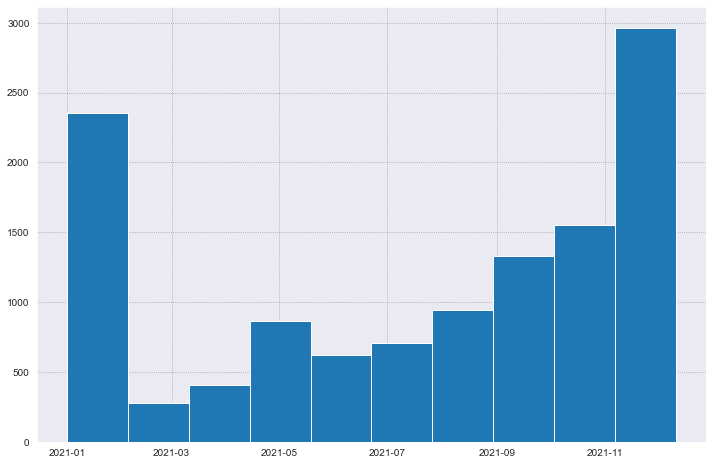

In [9]:
plt.figure(figsize = (12,8))
plt.hist(df_maxdate['Date'])
plt.show()

In [10]:
df_maxdate = df_maxdate[df_maxdate['Date'] >= '2021-08-01']
df = df.merge(df_maxdate, how='inner', left_on='id_Nomenclature', right_on='id_Nomenclature')
df.drop(['Date_y'], axis=1, inplace=True)
df = df.rename(columns={'Date_x': 'Date'})
df.head()

,Date,id_Nomenclature,InitialBalance,Coming,Expense
0,2021-01-01,517c47b0-757a-11e9-9c60-f8bc1246d741,3.0,0.0,0.0
1,2021-03-02,517c47b0-757a-11e9-9c60-f8bc1246d741,3.0,0.0,1.0
2,2021-02-26,517c47b0-757a-11e9-9c60-f8bc1246d741,2.0,2.0,0.0
3,2021-10-08,517c47b0-757a-11e9-9c60-f8bc1246d741,4.0,0.0,1.0
4,2021-01-09,517c47b0-757a-11e9-9c60-f8bc1246d741,3.0,0.0,1.0


In [11]:
len(df)

60378

In [12]:
df['id_Nomenclature'].nunique()

6592

# Отрезаем по количеству покупок

Также логично учитывать номенклатуры, которые расходовались достаточное количество раз. Это достаточное количество раз нужно подбирать. Это важно для построения модели, так как было решено обучать под каждую номенклатуру свою отдельную модель, нужна хотя бы какая-то выборка для хорошего обучения. Экспериментально выявлено, что лучший результат при ограничении количества расхода >= 12 раз. В результате проделанных действий для прогноза остается 1043 номенклатуры, для остальных прогноз 0.

In [13]:
df_count = df.groupby('id_Nomenclature').count()[['Expense']].reset_index()
df_count.head()

,id_Nomenclature,Expense
0,000a8a6e-b203-11ea-82cd-00ad2416633c,3
1,001f65ee-2829-11ec-8428-00ad2416633c,2
2,002a51b0-8c17-11e8-9980-f8bc1246d741,6
3,002f20f4-b20b-11ea-82cd-00ad2416633c,5
4,0038ea7a-80cb-11eb-838a-00ad2416633c,2


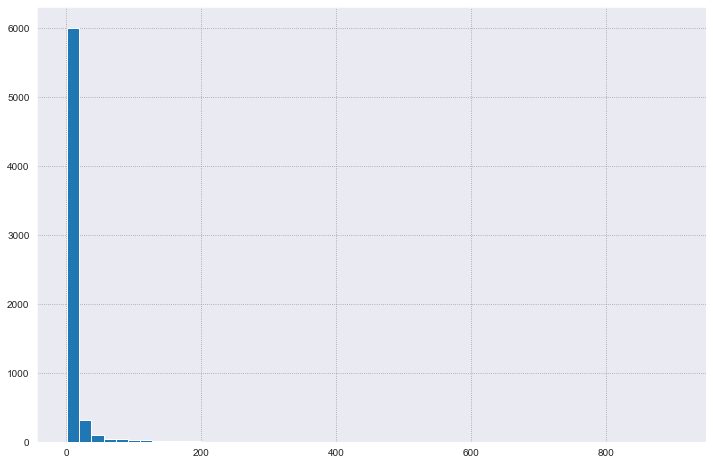

In [14]:
plt.figure(figsize = (12,8))
plt.hist(df_count['Expense'], bins=50)
plt.show()

In [15]:
df_count = df_count[df_count['Expense'] >= 12]
df = df.merge(df_count, how='inner', left_on='id_Nomenclature', right_on='id_Nomenclature')
df.drop(['Expense_y'], axis=1, inplace=True)
df = df.rename(columns={'Expense_x': 'Expense'})
df.head()

,Date,id_Nomenclature,InitialBalance,Coming,Expense
0,2021-01-01,2e47945d-cbe5-11ea-82e4-00ad2416633c,7.0,0.0,0.0
1,2021-01-21,2e47945d-cbe5-11ea-82e4-00ad2416633c,7.0,0.0,1.0
2,2021-07-05,2e47945d-cbe5-11ea-82e4-00ad2416633c,6.0,0.0,1.0
3,2021-05-17,2e47945d-cbe5-11ea-82e4-00ad2416633c,5.0,0.0,1.0
4,2021-05-26,2e47945d-cbe5-11ea-82e4-00ad2416633c,4.0,0.0,1.0


In [16]:
len(df)

41371

In [17]:
df['id_Nomenclature'].nunique()

1043

# Заполняем отсутствующие даты нулями

Для чего это нужно? 

* Немного разбавить выборку нулевыми расходами, так как мы хотим прогнозировать на все дни декабря там будет много нулевых расходов

* Это поможет собрать агрегации по всем месяцам для создания фичей

Появившиеся наны просто заполним нулями.

In [18]:
full_dates = pd.DataFrame([])
full_dates['Date'] = pd.date_range(start='2021-01-01', end='2021-12-31')
full_dates = full_dates.reset_index()
full_dates.head()

,index,Date
0,0,2021-01-01
1,1,2021-01-02
2,2,2021-01-03
3,3,2021-01-04
4,4,2021-01-05


In [19]:
full_nom = pd.DataFrame([])
full_nom['id_Nomenclature'] = list(df['id_Nomenclature'].unique()) * 365
res_id = []
for i in range(1, 366):
    res_id += ([i] * df['id_Nomenclature'].nunique())
full_nom['date_id'] = res_id
full_nom.head()

,id_Nomenclature,date_id
0,2e47945d-cbe5-11ea-82e4-00ad2416633c,1
1,07387690-6993-11e8-bbf0-f8bc1246d741,1
2,b8e93d7d-cbe5-11ea-82e4-00ad2416633c,1
3,9656df30-f6d6-11e8-8908-f8bc1246d741,1
4,58562a9b-8c35-11e9-80bb-f8bc12420fd1,1


In [20]:
full_dates = full_dates.merge(full_nom, how='inner', left_on='index', right_on='date_id')
full_dates.drop(['index', 'date_id'], axis=1, inplace=True)
full_dates.head()

,Date,id_Nomenclature
0,2021-01-02,2e47945d-cbe5-11ea-82e4-00ad2416633c
1,2021-01-02,07387690-6993-11e8-bbf0-f8bc1246d741
2,2021-01-02,b8e93d7d-cbe5-11ea-82e4-00ad2416633c
3,2021-01-02,9656df30-f6d6-11e8-8908-f8bc1246d741
4,2021-01-02,58562a9b-8c35-11e9-80bb-f8bc12420fd1


In [21]:
df_res = full_dates.merge(df, how='left', left_on=['Date', 'id_Nomenclature'] , right_on=['Date', 'id_Nomenclature'])
df_res.fillna(0, inplace=True)
df_res.head()

,Date,id_Nomenclature,InitialBalance,Coming,Expense
0,2021-01-02,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0
1,2021-01-02,07387690-6993-11e8-bbf0-f8bc1246d741,0.0,0.0,0.0
2,2021-01-02,b8e93d7d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0
3,2021-01-02,9656df30-f6d6-11e8-8908-f8bc1246d741,0.0,0.0,0.0
4,2021-01-02,58562a9b-8c35-11e9-80bb-f8bc12420fd1,0.0,0.0,0.0


# Агрегации

Какие фичи сгенерировать? Первая мысль это datetime фичи, это понятно, сделаем чуть позже. У нас есть признаки InitialBalance и Coming. В тесте мы их использовать не сможем, так как значения неизвестны, поэтому нужно придумать, как сохранять их информацию.

Предлагаю считать сумму и среднее по этим фичам, а также по Expence за предыдущий месяц и использовать это как новый признак. Почему лаг месяц? Так как для 31 декабря мы максимум можем учесть 30 ноября, поэтому приходится делать такой большой лаг. Небольшая проблема в том, что было добавлено много нулей, но с другой стороны это сделает ситуацию более реальной и при этом все равно можно сохранить информацию, которая хранится в данных признаках.

In [22]:
df_res_tmp = df_res.copy()
df_res_tmp = df_res_tmp.set_index('Date')
month_sum = df_res_tmp.groupby(by=[df_res_tmp.index.month, 'id_Nomenclature']).sum()['Expense'].reset_index().\
                                rename(columns={'Expense': 'prev_month_exp_sum'})
month_sum['Date'] += 1

month_mean = df_res_tmp.groupby(by=[df_res_tmp.index.month, 'id_Nomenclature']).mean()['Expense'].reset_index().\
                                rename(columns={'Expense': 'prev_month_exp_mean'})
month_mean['Date'] += 1

In [23]:
df_res['month'] = df_res['Date'].dt.month

df_res = df_res.merge(month_sum, how='inner', left_on=['id_Nomenclature', 'month'] , right_on=['id_Nomenclature', 'Date'])
df_res.drop(['Date_y'], axis=1, inplace=True)
df_res = df_res.rename(columns={'Date_x': 'Date'})

df_res = df_res.merge(month_mean, how='inner', left_on=['id_Nomenclature', 'month'] , right_on=['id_Nomenclature', 'Date'])
df_res.drop(['Date_y'], axis=1, inplace=True)
df_res = df_res.rename(columns={'Date_x': 'Date'})

df_res.drop(['month'], axis=1, inplace=True)

df_res.head()

,Date,id_Nomenclature,InitialBalance,Coming,Expense,prev_month_exp_sum,prev_month_exp_mean
0,2021-02-01,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,1.0,0.033333
1,2021-02-02,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,1.0,0.033333
2,2021-02-03,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,1.0,0.033333
3,2021-02-04,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,1.0,0.033333
4,2021-02-05,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,1.0,0.033333


In [24]:
df_res_tmp = df_res.copy()
df_res_tmp = df_res_tmp.set_index('Date')
month_sum = df_res_tmp.groupby(by=[df_res_tmp.index.month, 'id_Nomenclature']).sum()['InitialBalance'].reset_index().\
                                rename(columns={'InitialBalance': 'prev_month_ib_sum'})
month_sum['Date'] += 1

month_mean = df_res_tmp.groupby(by=[df_res_tmp.index.month, 'id_Nomenclature']).mean()['InitialBalance'].reset_index().\
                                rename(columns={'InitialBalance': 'prev_month_ib_mean'})
month_mean['Date'] += 1

In [25]:
df_res['month'] = df_res['Date'].dt.month

df_res = df_res.merge(month_sum, how='inner', left_on=['id_Nomenclature', 'month'] , right_on=['id_Nomenclature', 'Date'])
df_res.drop(['Date_y'], axis=1, inplace=True)
df_res = df_res.rename(columns={'Date_x': 'Date'})

df_res = df_res.merge(month_mean, how='inner', left_on=['id_Nomenclature', 'month'] , right_on=['id_Nomenclature', 'Date'])
df_res.drop(['Date_y'], axis=1, inplace=True)
df_res = df_res.rename(columns={'Date_x': 'Date'})

df_res.drop(['month'], axis=1, inplace=True)

df_res.head()

,Date,id_Nomenclature,InitialBalance,Coming,Expense,prev_month_exp_sum,prev_month_exp_mean,prev_month_ib_sum,prev_month_ib_mean
0,2021-03-01,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-03-02,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-03-03,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-03-04,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-03-05,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_res_tmp = df_res.copy()
df_res_tmp = df_res_tmp.set_index('Date')
month_sum = df_res_tmp.groupby(by=[df_res_tmp.index.month, 'id_Nomenclature']).sum()['Coming'].reset_index().\
                                rename(columns={'Coming': 'prev_month_com_sum'})
month_sum['Date'] += 1

month_mean = df_res_tmp.groupby(by=[df_res_tmp.index.month, 'id_Nomenclature']).mean()['Coming'].reset_index().\
                                rename(columns={'Coming': 'prev_month_com_mean'})
month_mean['Date'] += 1

In [27]:
df_res['month'] = df_res['Date'].dt.month

df_res = df_res.merge(month_sum, how='inner', left_on=['id_Nomenclature', 'month'] , right_on=['id_Nomenclature', 'Date'])
df_res.drop(['Date_y'], axis=1, inplace=True)
df_res = df_res.rename(columns={'Date_x': 'Date'})

df_res = df_res.merge(month_mean, how='inner', left_on=['id_Nomenclature', 'month'] , right_on=['id_Nomenclature', 'Date'])
df_res.drop(['Date_y'], axis=1, inplace=True)
df_res = df_res.rename(columns={'Date_x': 'Date'})

df_res.drop(['month'], axis=1, inplace=True)

df_res.head()

,Date,id_Nomenclature,InitialBalance,Coming,Expense,prev_month_exp_sum,prev_month_exp_mean,prev_month_ib_sum,prev_month_ib_mean,prev_month_com_sum,prev_month_com_mean
0,2021-04-01,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-04-02,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-04-03,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-04-04,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-04-05,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Datetime фичи

Вижу дату - делаю datetime фичи, тут все как обычно.

In [28]:
df_res['month'] = df_res['Date'].dt.month
df_res['day'] = df_res['Date'].dt.day
df_res['weekday'] = df_res['Date'].dt.weekday
df_res['week'] = df_res['Date'].dt.week

In [29]:
df_res.drop(['InitialBalance', 'Coming'], axis=1, inplace=True)

df_res.head()

,Date,id_Nomenclature,Expense,prev_month_exp_sum,prev_month_exp_mean,prev_month_ib_sum,prev_month_ib_mean,prev_month_com_sum,prev_month_com_mean,month,day,weekday,week
0,2021-04-01,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,1,3,13
1,2021-04-02,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2,4,13
2,2021-04-03,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,3,5,13
3,2021-04-04,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4,6,13
4,2021-04-05,2e47945d-cbe5-11ea-82e4-00ad2416633c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,5,0,14


# Построение модели

* Первая идея была использовать Ridge, но градиентный бустинг помогает немного улучшить итоговый скор.

* Как ранее было сказано, под каждую номенклатуру получаем свою модель

* Убираем почти дубли, которые появились на этапе генерации дат с нулевым расходом и агрегаций, чтобы сделать выборку более разреженной и сбалансированной.

* Логарифмируем таргет. Это помогает побороть выбросы и немного улучшает скор.

* Последний этап - удалить прогнозы меньше 0.9, будем считать их нулем. Порог был подобран по результатам экспериментов.

In [30]:
df_res = df_res.sample(frac=1, random_state=42)

df_train = df_res[df_res['Date'] < '2021-12-01']
df_test = df_res[df_res['Date'] >= '2021-12-01']
del df_res

In [31]:
print(len(df_train))


df_train.drop_duplicates(subset=['id_Nomenclature', 'Expense',
       'prev_month_exp_sum', 'prev_month_exp_mean', 'prev_month_ib_sum',
       'prev_month_ib_mean', 'prev_month_com_sum', 'prev_month_com_mean'], inplace=True)

print(len(df_train))

262117
15206


In [33]:
df_preds = pd.DataFrame([])

for nom_id in tqdm(df_train['id_Nomenclature'].unique()):
    df_train_tmp = df_train[df_train['id_Nomenclature'] == nom_id]
    df_test_tmp = df_test[df_test['id_Nomenclature'] == nom_id]
    
    y_train = np.log1p(df_train_tmp['Expense'])
    X_train = np.array(df_train_tmp.drop(['Expense', 'Date', 'id_Nomenclature'], axis=1))
    
    X_test = np.array(df_test_tmp.drop(['Expense', 'Date', 'id_Nomenclature'], axis=1))
    
    model = LGBMRegressor(random_state=1)
    model.fit(X_train, y_train)
    y_pred = np.expm1(model.predict(X_test))
    
    df_test_tmp['Expense'] = y_pred
    df_preds = pd.concat((df_preds, df_test_tmp), axis = 0)

del df_train_tmp
del df_test_tmp
del X_train
del y_train
del X_test

100%|██████████████████████████████████████████████████████████████████████████████| 1043/1043 [00:58<00:00, 17.90it/s]


In [34]:
df_preds = df_preds[['id_Nomenclature','Date','Expense']]
df_preds = df_preds[df_preds['Expense'] > 0.9]
df_preds['Date'] = df_preds['Date'].dt.strftime('%d.%m.%Y %H:%M:%S')
df_preds.to_json('preds.json', orient='records')

# Результаты

**Итоговый скор**

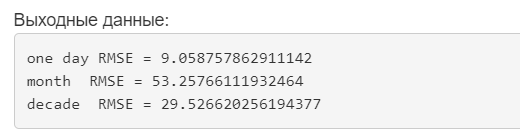

Удалось немного оторваться от бейслайна, большей идей как затюнить решение не появилось, сложная задача для генерации признаков, а тех, что есть, не совсем достаточно, чтобы получить значимый прирост.